In [1]:
import json
import numpy as np 
from collections import defaultdict 


In [2]:
def read_file(path):
    data_by_src = defaultdict(list)
    with open(path, "r") as f1:
        for line in f1:
            line = json.loads(line)
            # trim off last token (EOS)
            line['logit_at_label'] = np.array(line['logit_at_label'][0:-1])
            data_by_src[line['natural']].append(line)

    # for src, list_ in data_by_src.items():
        # assert(len(list_) == 2)

    return data_by_src


In [3]:
data_for_df = []

for model in ["codegen-350M", "codegen-2B", "codegen-6B", "codegen-16B"]:
    for t in ['pp', 'scope', 'revscope', 'bound']:
        
        path = f"/brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/{model}/{t}_fol_hit/outputs/dev_eval.logits"
        print(f"reading {path}")
        try:
            data_by_src = read_file(path)
        except FileNotFoundError:
            print(f"file not found: {path}")
            continue

        for src, lines in data_by_src.items():
            p_lf0, p_lf1 = None, None
            min_lf0, min_lf1 = None, None
            for line in lines:
                template_idx = str(line['template_idx'])
                total_prob = np.exp(np.sum(np.log(line['logit_at_label'])))

                min_logit_at_label = np.min(line['logit_at_label']) 
                if template_idx == '0':
                    min_lf0 = min_logit_at_label
                    p_lf0 = total_prob
                else:
                    min_lf1 = min_logit_at_label
                    p_lf1 = total_prob

            # turn into a proper probability by normalizing 
            norm_min_p_lf0 = min_lf0 / (min_lf0 + min_lf1)
            norm_total_p_lf0 = p_lf0 / (p_lf0 + p_lf1)

            data_for_df.append({"model": model, "amb_type": t,  "type": "norm_min_lf0", "value": norm_min_p_lf0, "inp_str": src}) 
            data_for_df.append({"model": model, "amb_type": t,  "type": "norm_total_lf0", "value": norm_total_p_lf0, "inp_str": src}) 


reading /brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/codegen-350M/pp_fol_hit/outputs/dev_eval.logits
reading /brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/codegen-350M/scope_fol_hit/outputs/dev_eval.logits
reading /brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/codegen-350M/revscope_fol_hit/outputs/dev_eval.logits
reading /brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/codegen-350M/bound_fol_hit/outputs/dev_eval.logits
reading /brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/codegen-2B/pp_fol_hit/outputs/dev_eval.logits
reading /brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/codegen-2B/scope_fol_hit/outputs/dev_eval.logits
reading /brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/codegen-2B/revscope_fol_hit/outputs/dev_eval.logits
reading /brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/codegen-2B/bound_fol_hit/outputs/dev_eval.logits
reading /brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/codegen-6B/pp_f

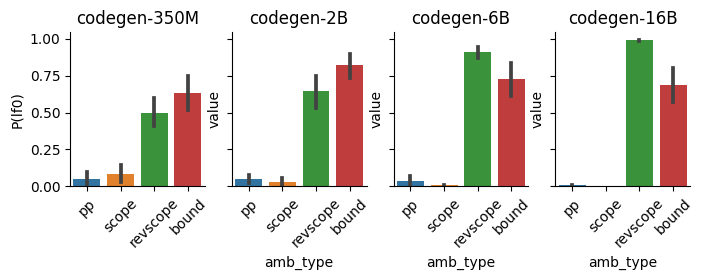

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt 
import pandas as pd

df = pd.DataFrame(data_for_df)

prob_df = df[df['type'] == "norm_total_lf0"]

fig, ax = plt.subplots(1, 4, figsize=(8,2), sharex=True, sharey=True)

for midx, model in enumerate(["codegen-350M", "codegen-2B", "codegen-6B", "codegen-16B"]):
    ax[midx].set_title(model)
    model_df = df[df['model'] == model]  
    sns.barplot(data = model_df, x = "amb_type", y = "value", ax=ax[midx])
    # rotate xticks 45 degrees
    for item in ax[midx].get_xticklabels():
        item.set_rotation(45)

ax[0].set_ylabel("P(lf0)")
ax[0].set_xlabel("")
sns.despine()


Index(['model', 'amb_type', 'type', 'value', 'inp_str', 'xval'], dtype='object')


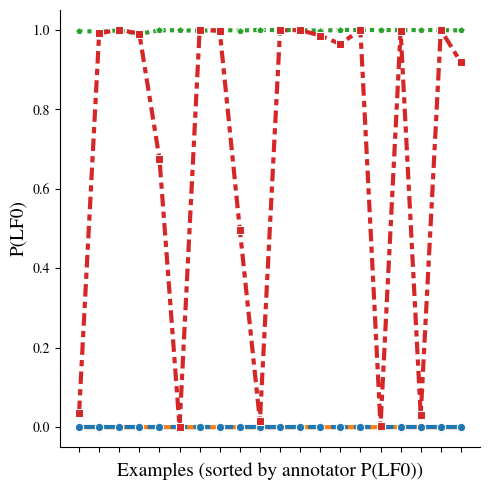

In [8]:
from colors import markers, colors 

plt.rcParams.update({"font.family": "Nimbus Roman"})

order_data = json.load(open("/home/estengel/ambiguous_parsing_hit/analysis/order_data.json"))

fig, ax = plt.subplots(1,1, figsize=(5,5), sharex=True, sharey=True) 

df_to_plot = []
worker = None
outvote = False


# def get_order(order_data, amb_type, str):
#     print(order_data[amb_type])
#     print(str)


def get_score(datapoint, worker=None, agg=np.mean):
    if worker is None:
        return agg(datapoint['p_lf0'])
    score_idx = datapoint['worker'].index(worker)
    return datapoint['p_lf0'][score_idx]

model = "codegen-16B"

new_df = []
prob_df = prob_df[prob_df['model'] == model]
for amb_type in ['scope', 'pp',  'revscope', 'bound']:
    data = prob_df[prob_df['amb_type'] == amb_type]
    # sort by order data 
    data = data.sort_values(by=['inp_str'], key=lambda x: [order_data[amb_type].index(i) for i in x])
    data['xval'] = range(len(data))
    new_df.append(data)
df = pd.concat(new_df)
    
print(data.keys())
sns.lineplot(data = df, 
            x = "xval", 
            y ="value", 
            hue='amb_type',  
            palette=colors,
            style="amb_type",
            markers=markers,
            linewidth=3)
sns.despine()

ax.set_ylabel("P(LF0)", fontsize=14)
ax.set_xlabel("Examples (sorted by annotator P(LF0))", fontsize=14)
ax.set_xticks([i for i in range(20)])
ax.set_xticklabels(['' for _ in range(20)])
ax.legend().remove()

plt.tight_layout()
plt.savefig("/home/estengel/papers/ambiguous-parsing-2023/figures/model_on_hit.pdf")